### Simple Neural Network Classifier with various inbalanced-learn over and under-sampling methods

Declarations for the ClaimDataset, ClaimClassifier and training functions can be found in claim_classifier.py 

In [1]:
from claim_classifier import *
from preprocessing import preprocess

import pandas as pd
import torch
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
train_file = "data/FRISS_ClaimHistory_training.csv"
test_file = "data/FRISS_ClaimHistory_test.csv"
fraud_file = "data/fraud_cases.csv"

train, test = preprocess(train_file, test_file, fraud_file)

Finished preprocessing.
Dropped 182 Train entries.
Dropped 43 Test entries.
Preprocessing took 2.35 seconds


In [3]:
drop_cols = ['occurred_year', 'occurred_month',
       'occurred_day', 'reported_year', 'reported_month', 'reported_day']

train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [4]:
train.columns

Index(['sys_claimid', 'claim_amount_claimed_total',
       'claim_location_urban_area', 'object_year_construction',
       'policy_fleet_flag', 'sys_fraud', 'claim_time_interval',
       'cause_Animals', 'cause_Collision', 'cause_Other', 'cause_Theft',
       'cause_Weather', 'make_AUDI', 'make_BMW', 'make_CITROEN', 'make_OPEL',
       'make_OTHER', 'make_RENAULT', 'make_VOLKSWAGEN', 'profitability_High',
       'profitability_Low', 'profitability_Neutral', 'profitability_Very high',
       'profitability_Very low', 'prev_claims'],
      dtype='object')

In [5]:
# # Basic Undersampling

# fraud_entries = train[train["sys_fraud"] == 1]
# non_fraud_entries = train[train["sys_fraud"] == 0].sample(len(fraud_entries))
# train = fraud_entries.append(non_fraud_entries).sample(frac=1.0)

In [6]:
# # Cluster Undersampling

# from imblearn.under_sampling import ClusterCentroids
# cc = ClusterCentroids(random_state=0)
# train, y = cc.fit_resample(train.drop(columns=["sys_fraud"]), train["sys_fraud"])
# train["sys_fraud"] = y
# train = train.sample(frac=1.0)

In [7]:
# Random Undersampler

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
train, y = rus.fit_resample(train.drop(columns=["sys_fraud"]), train["sys_fraud"])

train["sys_fraud"] = y
train = train.sample(frac=1.0)

In [8]:
# # SMOTE over-sampling

# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# train, y = smote.fit_resample(train.drop(columns=["sys_fraud"]), train["sys_fraud"])
# train["sys_fraud"] = y
# train = train.sample(frac=1.0)

In [9]:
# # Over and Under sampling

# from imblearn.combine import SMOTEENN
# smoteenn = SMOTEENN()
# train, y = smoteenn.fit_resample(train.drop(columns=["sys_fraud"]), train["sys_fraud"])
# train["sys_fraud"] = y
# train = train.sample(frac=1.0)

In [10]:
# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=0)
# train, y = smote_tomek.fit_resample(train.drop(columns=["sys_fraud"]), train["sys_fraud"])
# train["sys_fraud"] = y

# train = train.sample(frac=1.0)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns="sys_fraud"),
                                                    train["sys_fraud"],
                                                    test_size=0.10, random_state=42)

X_train["sys_fraud"] = y_train
train = X_train

X_val["sys_fraud"] = y_val
val = X_val

In [12]:
epochs = 60
max_patience = 5

if torch.cuda.is_available():    
  DEVICE = torch.device("cuda")
  print('Using:', torch.cuda.get_device_name(0))
else:
  print('Using: CPU')
  DEVICE = torch.device("cpu")

torch.manual_seed(1)

train_set = ClaimDataset(train)
val_set = ClaimDataset(val)
test_set = ClaimDataset(test)
train_dataloader = DataLoader(train_set, batch_size = 1, num_workers = 2, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size = 1, num_workers = 2, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size = 1, num_workers = 2, shuffle=False)

input_features = train_set.number_of_features()

model = ClaimClassifier(input_features)
model.to(DEVICE)

class_weights = compute_class_weight('balanced',
                                     classes = np.unique(train["sys_fraud"]),
                                     y = train["sys_fraud"])
#class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights = torch.tensor([1.0, 1.1])
print(class_weights)
criterion = nn.CrossEntropyLoss(weight = class_weights, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

model, preds, labels = train_model(model, criterion, optimizer, train_dataloader, val_dataloader, 
                                   DEVICE, epochs, max_patience)

Using: CPU
tensor([1.0000, 1.1000])
- - T R A I N I N G - -

> Epoch 1 of 60
└───Batch 1,107 of 1,107. time=3.0s.

- Training loss: 0.70
- Training Epoch took: 3.0s

- - V A L I D A T I N G - -

- Validation Accuracy: 0.5000
- Validation Precision: 0.9672
- Validation Recall: 0.4958
- Validation F1: 0.6556
- Validation AUROC: 0.6266
- Validation loss: 0.6890
- Validation took: 0.7s

Saving model...

> Epoch 2 of 60
└───Batch 1,107 of 1,107. time=2.9s.

- Training loss: 0.69
- Training Epoch took: 2.9s

- - V A L I D A T I N G - -

- Validation Accuracy: 0.6290
- Validation Precision: 0.7049
- Validation Recall: 0.6056
- Validation F1: 0.6515
- Validation AUROC: 0.6729
- Validation loss: 0.6703
- Validation took: 0.3s

> Epoch 3 of 60
└───Batch 1,107 of 1,107. time=3.0s.

- Training loss: 0.69
- Training Epoch took: 3.0s

- - V A L I D A T I N G - -

- Validation Accuracy: 0.6290
- Validation Precision: 0.4754
- Validation Recall: 0.6744
- Validation F1: 0.5577
- Validation AUROC: 0.677

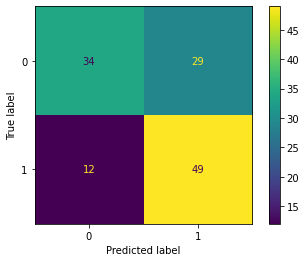

In [13]:
cm = confusion_matrix(labels, preds)best_model = ClaimClassifier(train_dataloader.dataset.number_of_features())
    best_model.load_state_dict(torch.load("savedmodels/{}".format(model_name)))
    best_model.eval()

cmd_obj = ConfusionMatrixDisplay(cm) 


cmd_obj.plot()

In [14]:
preds, labels, IDs = predict_model(model, criterion, optimizer, test_dataloader, DEVICE)

- - P R E D I C T I N G - -

- Prediction Accuracy: 0.4304
- Prediction Precision: 0.6912
- Prediction Recall: 0.0082
- Prediction F1: 0.0163
- Prediction AUROC: 0.5654
- Prediction loss: 0.9506
- Prediction took: 39.9s

Finished Predicting



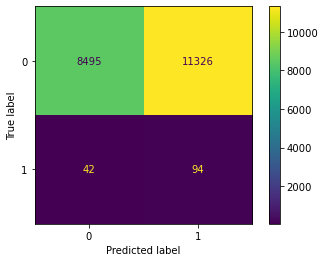

In [15]:
cm = confusion_matrix(labels, preds)

cmd_obj = ConfusionMatrixDisplay(cm) 

_ = cmd_obj.plot()

In [43]:
out.append({"ID":1, "prediction":2}, ignore_index=True)

,ID,prediction
0,140152636,1.0
1,783277250,1.0
2,653694965,0.0
3,251228076,0.0
4,550974082,0.0
...,...,...
19953,153849750,1.0
19954,931906496,1.0
19955,661998726,1.0
19956,594986363,0.0
